# Dynamical Systems Package

Note: These functions and files as currently described will work with those found in the branch titled "colby2" and "ethan2", not "main."

These two files must be included at the start of the file in order to import the correct packages being used and define the correct types and functions. In the "TypeRDS.jl" file, there are descriptions on how to define the Random Dynamical Systems (RDS) type being used below, along with methods to sample from them such as sampleTraj.

In [17]:
include("rds.jl")
include("graphics.jl")

distDisplay (generic function with 1 method)

We now begin to use some of the defined packages above to get the code compiled on basic inputs. We will explore each of these functions on specific examples below, but this block ensures that the compilation is completed for all of our currently implemented functions so that they can be run much faster throughout the rest of the Notebook.

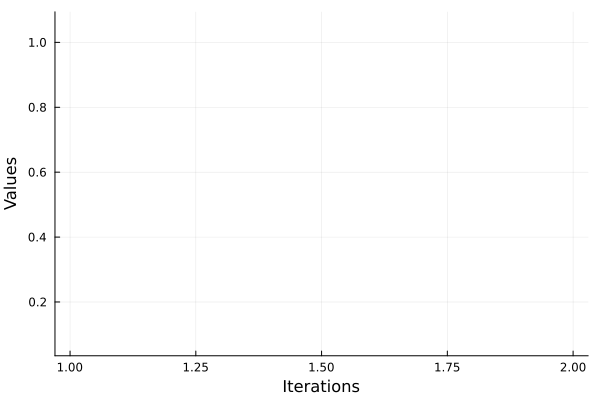

┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_Kdu3wRMvYv.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\rz1WP\src\animation.jl:156


Float64[]

In [18]:
function fω(ω, x)
    return x
end

function run()
    p(x) = x
    f(ω, x) = mod(ω, 1) * x
    rds = RDS(Interval{Closed, Closed}(0,1), 1 , Normal(), f)
    #fω(.3, [1], f)
    x=sampleTraj(rds, [.1], 1)
    timeseries(x, p)
    empiricalAverage(x)
    testing(x)
    tracking(x)
    sampling(1, Normal())
end
run()

The main goal is to build a Julia package that is capable of running simulations, or samples, of random dynamical systems. The core of our package is our `Type RDS`, which will contain all  necessary information related to our random dynamical system. Below is how one instantiates a `Type RDS`.

In the first implementation, our phase space $M$ is where we intend our results to lie within some interval subset of $\R$. An example construction is above, where Interval{Closed, Closed}(0,1) = [0, 1]. Next, the SampleSpaceDimension parameter indicates the dimension from which our samples will be drawn from. For example, if SampleSpaceDimension = 3, we will be drawing three real numbers ordered as a vector in $\R^{3}$ as our sample. Finally, the LawOfSamples parameter indicates from which distribution we will be drawing our sample from. In the above example, the SND was used, but we intend to allow users to evolve their systems from whichever distribution they prefer. Additionally, it could be possible for users to define their own distributions as long as they follow the same formatting and requirements described in the "Distributions.jl" package. There may be future ideas regarding removing the type restriction from this parameter, but this should work for now.

Note that the second implementation is essentially the same as the first, with the main difference being the use of $lM$ and $uM$ as the lower and upper bounds, respectively, for $M$ instead of an interval range. The other two parameters are the same. Both of these constructors could be useful for the user, so for now we are working with both.

In [19]:
struct RDS1
    M::Interval                 # Phase Space M.
    SampleSpaceDimension::Int   # Dimesnion of Ω₀    
    LawOfSamples::Distribution  # Distribution of Ω₀
    func::Function              # fω
end

struct RDS2
    lM::Float64                 # Lower bound of phase space M.
    uM::Float64                 # Upper phase space M.
    SampleSpaceDimension::Int   # Dimesnion of Ω₀    
    LawOfSamples::Distribution  # Distribution of Ω₀
end

f(ω, x) = mod(ω, 1) * x
rds1 = RDS1(Interval{Closed, Closed}(0,1), 1, Normal(), f)
rds2 = RDS2(0, 1, 1, Normal())

RDS2(0.0, 1.0, 1, Normal{Float64}(μ=0.0, σ=1.0))

When evaluating our random dynamical system over time, it is common for our initial data vector, $X_0$, to be sampled from a distribution. Below shows initial data vectors sampled from different distributions. We know that the SLLN should hold for this distributions as we take a larger number of samples, and we see that it indeed does approach the true values for each of their respective PDF's. We are doing this using method `sampling(n, dist)`, which takes `n` samples from distribution `dist` over the interval $[0,1]$ and plots the resulting histogram over this interval.

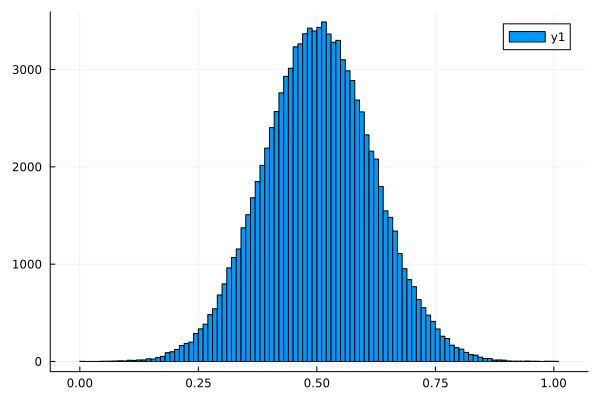

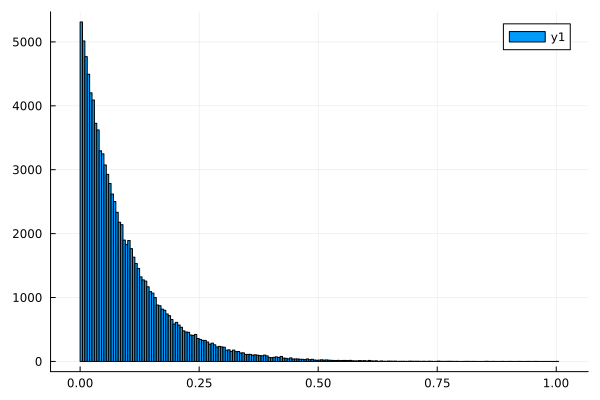

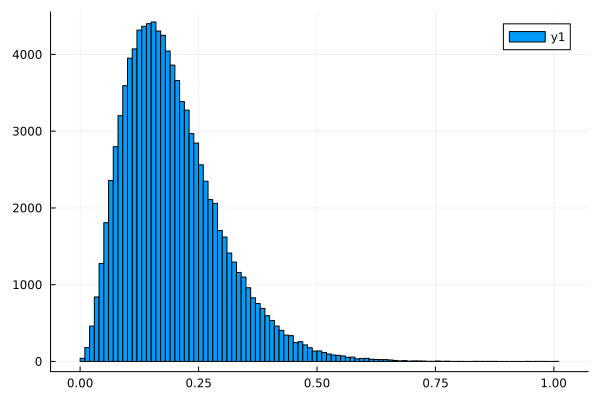

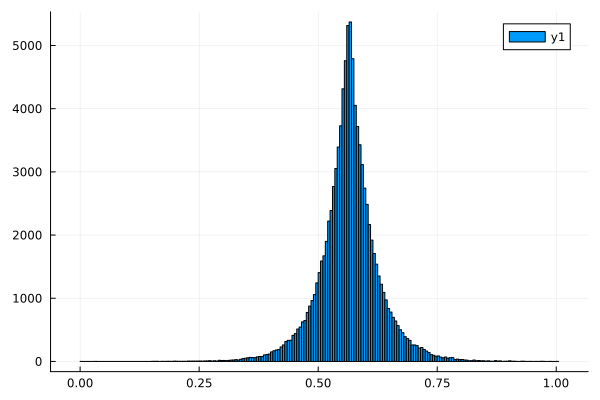

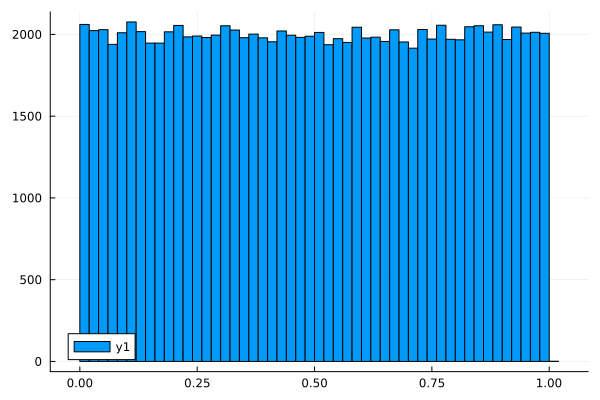

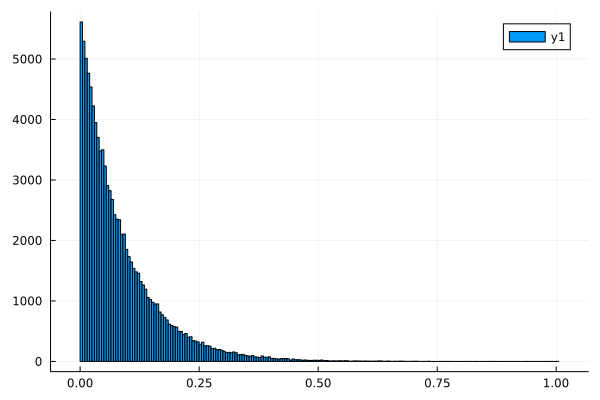

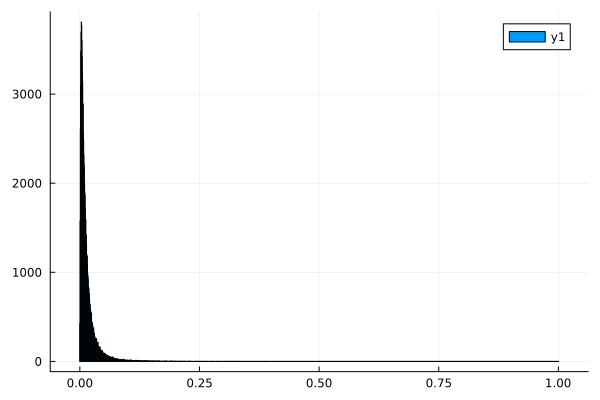

In [20]:
distributions = [Normal(), Exponential(), Chisq(8), Laplace(), Beta(), Erlang(), LogNormal()]
for dist in distributions
    display(histogram(sampling(100000, dist)))
end

As far as evolving our initial data overtime, we will be interested in the following composition:
$$f^n = f_{\omega_n} \circ \cdots \circ f_{\omega_1}: M \to M$$
where $f: \Omega_0 \times M \to M, (\omega, x) \mapsto f_\omega(x)$. If the $\omega_i$ are IID, then the sequence of random variables
$$X_n = f_{\omega_n}(X_{n-1})$$
forms a Markov chain on M. $f_{\omega_i}$ is what is moving our random dynamical system forward. For example, let $X_0 = [0.1, 0.2, 0.3]$ and $f(\omega, x) = (x + \omega) \pmod{1}$. If $\omega$ is sampled to be 2.5, then  
$$X_1 = X_0 + 2.5 \text{ (mod 1)} = X_0 + 0.5 =  [.6, .7, .8].$$



## Sampling
It would be helpful to have a method that samples a trajectory of a RDS through n iterations. That is what `sampleTraj` is used for. It takes in four parameters:
- `System::RDS` - Our random dynamical system.
- `n::Int64` - Length of wanted trajectory.
- `x0` - Initial data vector.
- `func::Function` - $f_\omega$

Here are some sample traejctory demos using the same distributions as above. After we run `sampleTraj`, we will run a method `tracking` which will produce a gif displaying the evolution of our system!

┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_sr8hCdSBCD.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\littl\\AppData\\Local\\Temp\\jl_sr8hCdSBCD.gif")
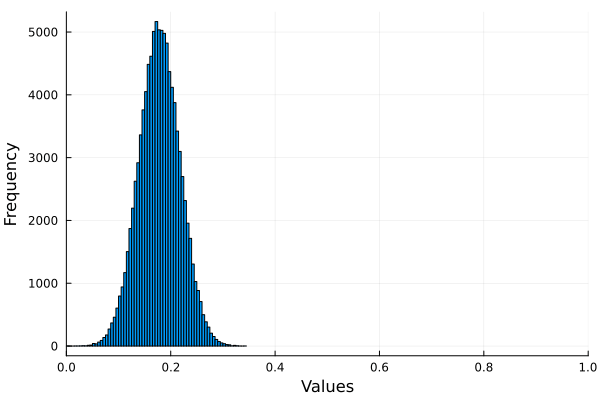

In [21]:
x0 = sampling(100000, Normal())
a(ω, x) = mod(ω, 1) * x
rds = RDS(Interval{Closed, Closed}(0,1), 1, Normal(), a)

traj = sampleTraj(rds, x0, 10)
tracking(traj)

This analytically checks out! Starting with $X_0$, every value is multiplied by the constant $0 < \omega$ mod $1<1$. So 
$$X_1 \sim \text{Norm}(c\mu, c^2\sigma^2)$$ 
where $c = \omega$ mod 1. So we expect our mean and standard deviation to decrease. As $n \to \infty,$ we have $X_n = 0.$ 

Our next example deals with the function $f(\omega, x) = x + (\frac{\omega \text{ mod } 1}{5})$. What do we expect this function to do? Since $\omega \text{ mod } 1 > 0,$ we expect our distribution to shift to the right (mod our phase space). Dividing by 5 makes the visualization nicer (assures not too large of leaps between states). What would you expect to occur when we use the function $g(\omega, x) = x - (\frac{\omega \text{ mod } 1}{5}) $ instead?



┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_qXCPm9azuf.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\littl\\AppData\\Local\\Temp\\jl_qXCPm9azuf.gif")
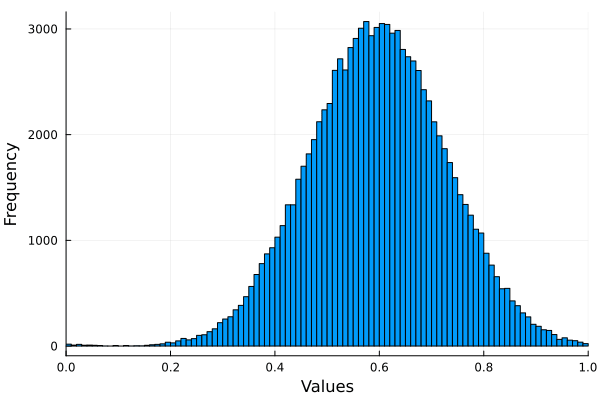

In [22]:
function fω(ω::Float64, x::Float64)
    return x + (mod(ω, 1) / 5)
end

x0 = sampling(100000, Normal())
rds = RDS(Interval{Closed, Closed}(0,1), 1, Normal(), fω)

traj = sampleTraj(rds, x0, 100, type="annealed")
tracking(traj)

Let $\phi: M \to \mathbb{R}$. This is known as an observable on our phase space $M$. Given a trajectory through $n$ iterations, the sequence
$$\{\phi(X_i)\}_{i=0}^n$$
is known as a time series. The average
$$\frac{1}{n}\sum_{i= 0}^{n-1}\phi(X_i)$$
is known as the $n^{th}$ empirical average. It is important for users to have functions that can do these computations for a given random dynamical system. `timeseries()` and `empiricalAvgs()` do these computations for us.

`timeseries` has two parameter:
- `traj::AbstractVector`: Provided trajectory,
- `ϕ::Function`: A function to apply to each data point.

`empiricalAverages` takes in one parameter, that being the trajectory we want to find the empirical average of.

# Random Observables

We now intend to describe an additional implementation of the `timeseries` and `empiricalAverage` using the concept of random observables. We still have the notion of an observable $\phi$ as described in the previous section, but now we can think of these random observables as $\omega$-dependent observables, $ϕ_{\omega}$, where each iteration of our RDS defined by $f_{\omega}$ has the $\omega$ values interact directly with our observable. Thus, we have new definitions for our `timeseries()` and `empiricalAverage()` functions by, respectively:

$$ \{ \phi_{\omega_{i+1}} (X_{i}) \} _{i = 0}^{n - 1} = \{ \phi_{\omega_{i+1}} \circ f_{\omega_{i}} \circ \cdots \circ f_{\omega_{1}} (X_{0}) \}_{0}^{n - 1}, $$

$$ \frac{1}{n} \sum_{0}^{n - 1} \phi_{\omega_{i+1}} (X_{i}) = \frac{1}{n} \sum_{0}^{n - 1} \left[ \phi_{\omega_{i+1}} \circ f_{\omega_{i}} \circ \cdots \circ f_{\omega_{1}} (X_{0}) \right]. $$

How do we implement this? Well, we have two implementations for the `timeseries` function. The first is the non-random observable case, which is described in the previous section, and the second has the same two parameters but with an additional `omegas` parameter that describes the now-$\omega$ dependence of our random observable $ϕ_{\omega}$. For the `empiricalAverage`, we do not need to change our function at all because the function only takes in a trajectory vector `traj` from any setting, whether it be from the main `sampleTraj` method, the original `timeseries` method, the random observables `timeseries` method, or any other! So, let's examine an example to see the new implementation of the `timeseries` functions.


In [23]:
# General timeseries function that we intend to use
function ϕ(x)
    return 1 + x
end

# Random observable function that we intend to use
function ϕω(ω, x)
    return ω + x
end

# Function for our RDS
function fω(ω::Float64, x::Float64)
    return mod(ω, 1) * x
end

x0 = sampling(100000, Normal())                                      # Initial Samples
rds = RDS(Interval{Closed, Closed}(0,1), 1, Normal(), fω)            # RDS
traj, omegas = sampleTraj(rds, x0, 10, type="quenched", RO=true)             # Our Trajectory with Omega Values Used

timeSeries0 = timeseries(traj, ϕ)                                    # Non-Random Observable
timeSeries1 = timeseries(traj, ϕω, omegas)                           # Random Observable

timeSeries1[1][1] - traj[1][1] == omegas[1]

true

# Making Distributions

It would be nice to be able to automate the construction of distributions on different domains. In other words, given a d-dimensonal domain $M$ and $f$, a multivariate distribution with the same dimension as $M$, construct a new distribution $g$  supported on $M$. 

We first implement a type `RDSDomain` which takes into account the dimension of our domain and which dimensions are mod 1. For example, the torus, $\mathbb{T^2}$, is of dimension 2, where each dimension is mod 1. From here, we can then use a method like `makeDistribution(M::RDSDomain, f::Distribution, truncation::Int64)` to construct a new distribution $g$  from our initial distribution $f$. 

Let us take, for example, $\mathbb{T^2}$ and understand what $g$ is analytically. Given an initial multivariate distribution with density $f: \mathbb{R^d} \to \mathbb{R}$, our new density on the torus would be

$$g(x) = \sum_{n \in \mathbb{Z^n}} f(x + n).$$

This makes sense! Because the torus is mod 1 in both dimension, any point in $R^d$ that is relate to another point by an integer vector shift is the same point on the torus. So we take this into account when creating our new density. If we are dealing with a domain that does not have all mod 1 dimension, our sum slightly changes. Instead of iterating over all integer vectors, we only look at integer vectors where the nonzero elements of are vector correspond to the mod 1 dimensions.

For example,  if $M = \mathbb{T} \times \mathbb{R}$, we iterate over all vectors of the form $(n, 0), n \in \mathbb{Z}$.


In [24]:
mutable struct RDSDomain
    dim::Int
    modulo_coordinates::Vector{Bool} 
end

function makeDistribution(M::RDSDomain, f::Distribution, truncation::Int64)
    if M.dim != length(f)
        throw(ArgumentError("Dimension for domains of M and f must match!"))
    end

    function g(x::Vector)
        range = -truncation:truncation
        total = pdf(f, x)
        zero = [i for i in 1:length(M.modulo_coordinates) if M.modulo_coordinates[i] == false]
        modulos = [i for i in 1:length(M.modulo_coordinates) if M.modulo_coordinates[i] == true]
        translator = Vector{}(undef, M.dim)

        for elt in Iterators.product(fill(range, length(modulos))...)
            # Take into account the modulo of our domain M.
            vals = collect(elt)
            translator[zero] .= 0
            translator[modulos] = vals
            if translator != zeros(M.dim)
                total += pdf(f, x .+ translator)
            end
        end
        return total
    end
    return g 
end

makeDistribution (generic function with 1 method)

Let's see the distribution constructed on $\mathbb{T^2}$ given our initial distribution is the standard normal multivariate distribution.

┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_A9oRYJ69Af.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\littl\\AppData\\Local\\Temp\\jl_A9oRYJ69Af.gif")
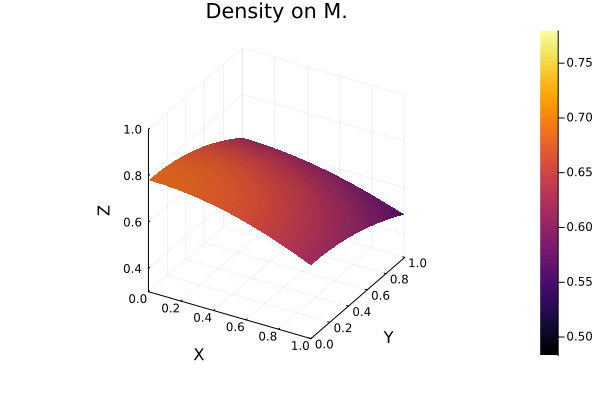

In [25]:
domain = RDSDomain(2, [true, true])
dist = MultivariateNormal([0, 0], [1 0.0; 0.0 1])
x = 0:.1:1
y = 0:.1:1

@gif for i in 1:10
    g = makeDistribution(domain, dist, i)
    zs = [g([xs,ys]) for ys in y, xs in x]
    surface(x, y, zs, zlims=(.3,1), xlabel="X", ylabel="Y", zlabel="Z", title="Density on M.")
end fps = 2

What about for $M = \mathbb{R} \times \mathbb{T}$?

┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_GTGP2hMHml.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\littl\\AppData\\Local\\Temp\\jl_GTGP2hMHml.gif")
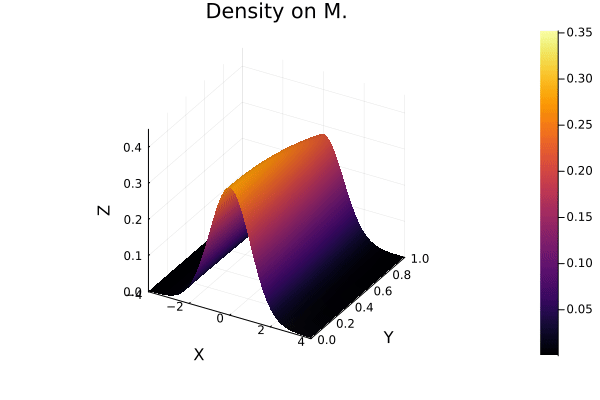

In [26]:
domain = RDSDomain(2, [false, true])
dist = MultivariateNormal([0, 0], [1 0.0; 0.0 1])
x = -4:.1:4
y = 0:.1:1

@gif for i in 1:7
    g = makeDistribution(domain, dist, i)
    zs = [g([xs,ys]) for ys in y, xs in x]
    surface(x, y, zs, xlabel="X", ylabel="Y", zlims=(0, .45), zlabel="Z", title="Density on M.")
end fps = 2


Now, what if we wanted to make a function that took in as inputs given domains (with associated distributions) and outputted values in $\mathbb{R}$? This is where the cross product make distribution function comes into play! Take a look at an example of a PDF of an equally mixed Normal and Beta distribution below.

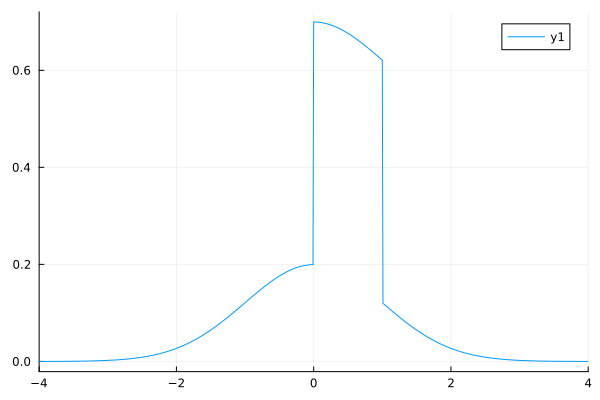

In [27]:
dist1 = Normal()
dist2 = Beta()

# Assign weights to each PDF value
weights = [0.5, 0.5]  # Replace with appropriate weights

# g: R × R -> R
g = makeDistributionCross([dist1, dist2], weights)

# randNorm = randn(1)[1]
# vals = g([randNorm, randNorm])
# println(vals)

xVals = -4:0.01:4

newPDF = Vector{}()
for val in xVals
    push!(newPDF, g([val, val]))
end

plot(xVals, newPDF, xlims=(-4, 4))

This still integrates to one, so a new density on $\mathbb{R} \times \mathbb{R}$ has been formed from the two initial distributions. What if we wanted to blend more than just two distributions to create a new PDF?

┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_E1ih6pMtS7.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\littl\\AppData\\Local\\Temp\\jl_E1ih6pMtS7.gif")
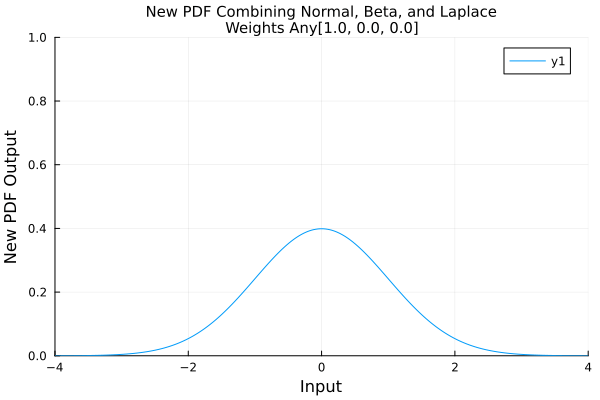

In [28]:
dist1 = Normal()
dist2 = Beta()
dist3 = Laplace()
gr()

distList = [dist1, dist2, dist3]

# Record and display distribution evolution over time.
@gif for i in 0:0.01:1 fps = 3
    # weights = [1-i, i]
    weights = [1-i, i/2, i/2]

    g = makeDistributionCross(distList, weights)

    xVals = -4:0.01:4

    newPDF = Vector{}()
    for val in xVals
        push!(newPDF, g([val, val, val]))
    end

    printWeights = Vector{}()
    for val in weights
        push!(printWeights, round(val, digits=2))
    end

    plot(xVals, newPDF, xlims=(-4,4), ylims=(0,1), title="New PDF Combining Normal, Beta, and Laplace\nWeights $printWeights", titlefont=font(10), xlabel="Input", ylabel="New PDF Output") # Plot the values sampled above
end

# BigFloat

In the Julia language, the type Float64 is the go-to standard type used to representing numbers with decimal portions. However, there are also cases where extra precision is required, more than that of Float64. Thus, another type called BigFloat is a great option implemented in Julia. Just look at that extra precision below!

In [29]:
num = 1.982072894762749274924

println(num)
println(typeof(num))

newNum = BigFloat(num)
println(newNum)
println(typeof(newNum))

1.9820728947627493
Float64
1.982072894762749282193681210628710687160491943359375
BigFloat


So, using this our framework, we would also like to be able to sample BigFloat values from different (univariate) distributions from the `Distributions.jl` package. In our experiments with this, however, we found that many of the univariate distributions do not have these capabilities. Those that do not are:

$\texttt{Beta}(\alpha, \beta)$: Beta Distribution.
$\\$
$\texttt{Gamma}(\alpha, \beta)$: Gamma Distribution.
$\\$
$\texttt{InverseGamma}(\alpha, \beta)$: Inverse Gamma Distribution.
$\\$
$\texttt{Chi}(k)$: Chi Distribution.
$\\$
$\texttt{Chisq}(k)$: Chi-squared Distribution.
$\\$
$\texttt{FDist}(d1, d2)$: F-Distribution.
$\\$
$\texttt{TDist}(\nu)$: t-Distribution.
$\\$
$\texttt{LogNormal}(\mu, \sigma)$: Log-Normal Distribution.
$\\$
$\texttt{Levy}(\mu, c)$: Levy Distribution.

On an important note, we found that we can sample BigFloats from the Normal distribution! This is very important to have, and the developers of Julia most likely implemented this in a recent update to Julia; be sure you have updated your version of Julia! Here is an example below, using our `sampling` method.

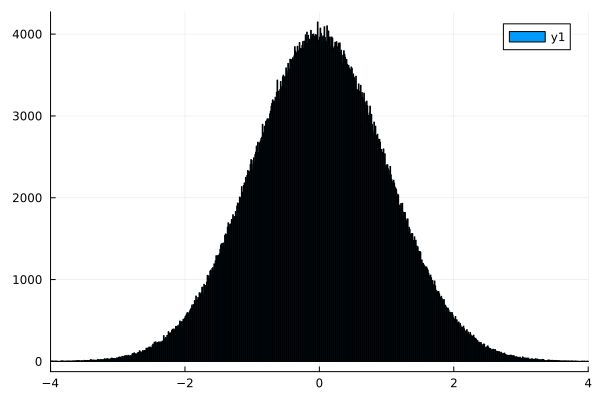

In [30]:
function sampling(n::Int, distribution::Distribution; precision=false) 
    # If precision is true, we want to use BigFloat.
    if precision==true
        # To randomly sample BigFloats from distribution, we use the inverse CDF function.
        # Does not always work, depending on the given univariate distribution
        if isa(distribution, Normal)
            precision=2^9
            dist = Normal(BigFloat(0, precision), BigFloat(1, precision))
            samples = rand(dist, n)
        else
            uni=rand(BigFloat, n)
            samples=quantile(distribution, uni)
        end
    else
        samples = rand(distribution, n)
    end
    transformed_samples = (samples .- minimum(samples)) / (maximum(samples) - minimum(samples))  # Transform samples to the interval [0, 1]
    valid_samples = filter(x -> 0 ≤ x ≤ 1, transformed_samples)  # Filter out values outside [lower, upper]
    return valid_samples
end

precision = 2^9  # Adjust as needed
dist = Normal(BigFloat(0, precision), BigFloat(1, precision))
samples = rand(dist, 1000000)

for val in samples
    if typeof(val) != BigFloat
        print("NOT BigFloat")
        break
    end
end

xLB, xUB, binsNum = -4, 4, 1000
histogram(samples, bins=binsNum, xlims=(xLB, xUB))
display(current())

Finally, one additional implementation is approximating the BigFloat value of a Float64 number. To do so, we can sample uniformly over the base-10 digits [0, 1, ..., 9] and add digits to the decimal expansion of a Float64 number and convert to a BigFloat. Here is an example.

In [31]:
function makeBigFloat(num::Float64, digits::Int64)
    unif = Uniform()
    strNum = string(num)

    # Create blank array
    newNumArray = [""]
    for x in range(1, length(strNum) - 1)
        push!(newNumArray,"")
    end

    # Replace each array with the character position of the given number
    for i in range(1, length(strNum))
        newNumArray[i] = string(strNum[i])
    end

    addDigits = Vector{}()
    # Uniformly sample a digit from [0, 1, ..., 9] to add to the end of the sample
    for i in 1:digits
        push!(addDigits, string(Int(floor(10 * rand(unif)))))
    end

    # Add newly generated digits to the original number
    for val in addDigits
        push!(newNumArray, val)
    end

    # Make everything into one string
    newString = ""
    for dig in newNumArray
        newString *= dig
    end

    # Convert to BigFloat
    return parse(BigFloat, newString)
end

makeBigFloat (generic function with 1 method)

In [32]:
println(17.2176738928748689143)
println(typeof(17.2176738928748689143))
val = makeBigFloat(17.2176738928748689143, 100)
println(val)
println(typeof(val))

17.21767389287487
Float64
17.21767389287487938140598449094595252730169712996054196254058550908951544618409
BigFloat
